<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [296]:
import pandas as pd
import numpy as np

from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor



from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, NMF


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer


from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


pd.set_option('display.max_column', None)

import warnings
warnings.filterwarnings('ignore')

In [255]:
def read_scv(res1, res2):
    # считываем файл, столбец с датой - в индекс
    try:
        df = pd.read_csv(res1, index_col='date')
    except:
        df = pd.read_csv(res2, index_col='date')
    return df

def search_features_output(data):
    # ищем столбцы с выбросами
    outputs = []
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        if data[(data[column]<Q1-1.5*IQR)|(data[column]>Q3+1.5*IQR)].shape[0] > 0:
            outputs.append(column)
    return outputs

def drop_output_iqr(data, level=1.5):
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        data = data[(data[column]>=Q1-level*IQR)&(data[column]<=Q3+level*IQR)]
    return data

def drop_output_95(data, q_down=0.025, q_up=0.975):
    for column in data.columns:
        floor = data[column].quantile(q_down)
        ceiling = data[column].quantile(q_up)
        data = data[(data[column]>=floor)&(data[column]<=ceiling)]
    return data
        
def find_recovery(C, F, T):
    recovery = 100*(C*(F-T))/(F*(C-T))
    return recovery
     
def look_concentrate(ore, input_concentrate, rougher, cleaner, final, df):
    print("Смотрим на концентрацию", ore, 'на разных этапах')

    sns.set(rc={'figure.figsize':(20,8)})

    plt.subplot(1, 4, 1)
    plt.xlabel('концентрация')
    plt.ylabel('частота')
    plt.title('сырьё')
    sns.histplot(x=input_concentrate, data=df)

    plt.subplot(1, 4, 2)
    plt.xlabel('концентрация')
    plt.ylabel('частота')
    plt.title('в черновом концентрате')
    sns.histplot(x=rougher, data=df)

    plt.subplot(1, 4, 3)
    plt.xlabel('концентрация')
    plt.ylabel('частота')
    plt.title('после первой очистки')
    sns.histplot(x=cleaner, data=df)

    plt.subplot(1, 4, 4)
    plt.xlabel('концентрация')
    plt.ylabel('частота')
    plt.title('в финальном концентрате')
    sns.histplot(x=final, data=df);

def look_feed_size(column, df1, title1, df2, title2, roof=150):
    sns.set(rc={'figure.figsize':(20,8)})

    plt.subplot(1, 2, 1)
    plt.xlabel('размер гранул')
    plt.ylabel('частота')
    plt.title(title1)
    sns.histplot(x=column, data=df1[df1[column]<roof])

    plt.subplot(1, 2, 2)
    plt.xlabel('размер гранул')
    plt.ylabel('частота')
    plt.title(title2)
    sns.histplot(x=column, data=df2[df2[column]<roof]);

def smape(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return np.mean(np.abs(y - y_pred) / ((np.abs(y) + np.abs(y_pred)) / 2)) * 100

def smape_itog(y_roughher_pred, y_roughher_test, y_final_pred, y_final_test):
    return 0.25*smape(y_roughher_pred, y_roughher_test) + 0.75*smape(y_final_pred, y_final_test)


**1.1.** Откроем и посмотрим данные.

In [256]:
# столбец с datetime мы передаем в индекс
df_train = read_scv('gold_industry_train.csv', '/datasets/gold_industry_train.csv')
df_test = read_scv('gold_industry_test.csv', '/datasets/gold_industry_test.csv')
df_full = read_scv('gold_industry_full.csv', '/datasets/gold_industry_full.csv')

print(f'Размер тренировочной выборки - {df_train.shape}')
print(f'Размер тестовой выборки - {df_test.shape}')
print(f'Размер полной выборки - {df_full.shape}')

df_full.head(2)

Размер тренировочной выборки - (14579, 86)
Размер тестовой выборки - (4860, 52)
Размер полной выборки - (19439, 86)


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.37500,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,11.836743,6.005818,41885.707031,3481.779053,3520.337158,2.838687,19.793808,11.500771,7.101074,28.029297,87.107763,1.170244,5.008018,0.508728,19.154297,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,34.174427,8.547551,10.389648,19.529297,2.106679,14.936526,2.534912,7.476074,25.853109,-498.526489,23.89366,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,2.606185,14.500184,4.694824,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.2

Видим, что в тестовой выборке 52 признака, в остальных 86. Исходить будем из того, что тренировочную модель сможем обучать только на таких признаках, которые есть в тестовой. Так же отметим, что в тестовой выборке нет целевых переменных

In [257]:
# проверим на полные дубликаты
df_full.duplicated().sum()

0

In [258]:
# Посмотрим на датасеты
print(df_test.info())
print(df_train.info())
print(df_full.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a_air             4859 non-null   float64
 9   rougher.state.floatbank10_a_level           4859 non-null

Признаков очень много (непривычно, но 'се ля ви'). Все признаки - тип float64.  
Для модели нам понадобятся только признаки, которые есть в тестовой выборке. Предполагается, что на начальном этапе, на котором нужно делать прогнозирование наличия золота многих данных еще нет, а появляются только в процессе тех обработки руды.  
Радует то, что хотя бы целевые переменные rougher.output.recovery и final.output.recovery без пропусков.   
Ради интереса посмотрим на признаки, которых нет в тестовой выборке.  


In [259]:
# Немножко масло маслянное. Генератор списков - для всех х, что есть в full но нет в тест
df_full[[x for x in df_full.columns if x not in df_test.columns]].columns

Index(['rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.recovery',
       'rougher.output.tail_au', 'rougher.output.tail_ag',
       'rougher.output.tail_pb', 'rougher.output.tail_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_ag',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'secondary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_ag',
       'secondary_cleaner.output.tail_pb', 'secondary_cleaner.ou

Итак, видим, что есть все четыре этапа: rougher, primary_cleaner, secondary_cleaner, final.  
Но из тип_параметра - только calculation для rougher и output для всех этапов.  

In [260]:
# Беглый осмотр признаков позволяет нам... сломать глаза.
df_full.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19395.000000,18986.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,19439.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439

Вручную глазками просматривать 86 (и даже 52) признаков мягко говоря утомительно. Попробуем выбрать только те, где:
- есть только в тестовой выборке  "И"
- есть пропуски  "ИЛИ"
- есть выбросы (Выбросы будем определять по 1,5 расстояния IQR от первого и третьего квантиля) 

In [261]:
# это будут признаки, которые возьмем за основу для модели
features = df_test.columns.to_list()

# посмотрим пропуски по столбцам
df_full[features].isna().sum()

rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_sol                         99
rougher.input.feed_rate                        11
rougher.input.feed_size                       145
rougher.input.floatbank10_sulfate              34
rougher.input.floatbank10_xanthate              8
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air               436
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0
rougher.state.floatbank10_f_level               0


Видим, что часть признаков пропущена незначительно - единицы, десятки, а часть пропусков пропущена прилично - сотни. таких крупных - 6 шт.
Если от первых можно не задумываясь избавиться - дропнуть или заполнить медианой, то другие надо посмотреть повнимательнее.

In [262]:
missed = []
for i in df_full[features].isna().sum().index:
    if df_full[features].isna().sum().loc[i] >= 100:
        missed.append(i)

missed

['rougher.input.feed_pb',
 'rougher.input.feed_size',
 'rougher.state.floatbank10_e_air',
 'rougher.input.floatbank11_xanthate',
 'primary_cleaner.input.xanthate',
 'secondary_cleaner.state.floatbank2_a_air']

In [263]:
df_full[[*missed, 'rougher.output.recovery', 'final.output.recovery']].corr()

,rougher.input.feed_pb,rougher.input.feed_size,rougher.state.floatbank10_e_air,rougher.input.floatbank11_xanthate,primary_cleaner.input.xanthate,secondary_cleaner.state.floatbank2_a_air,rougher.output.recovery,final.output.recovery
rougher.input.feed_pb,1.000000,-0.054133,-0.350495,0.064683,0.110320,0.042443,0.184540,0.175646
rougher.input.feed_size,-0.054133,1.000000,-0.035018,0.099848,0.057861,0.021041,0.039087,0.048744
rougher.state.floatbank10_e_air,-0.350495,-0.035018,1.000000,-0.020405,-0.168751,-0.108899,-0.083158,-0.095410
rougher.input.floatbank11_xanthate,0.064683,0.099848,-0.020405,1.000000,0.414596,-0.003380,0.241153,0.328231
primary_cleaner.input.xanthate,0.110320,0.057861,-0.168751,0.414596,1.000000,-0.167018,0.144265,0.206445
secondary_cleaner.state.floatbank2_a_air,0.042443,0.021041,-0.108899,-0.003380,-0.167018,1.000000,0.127209,0.109825
rougher.output.recovery,0.184540,0.039087,-0.083158,0.241153,0.144265,0.127209,1.000000,0.327059
final.output.recovery,0.175646,0.048744,-0.095410,0.328231,0.206445,0.109825,0.327059,1.000000


Итак. как можно поиграться с пропусками:
- дропнуть строки. Минус - теряем существенную часть данных 20-25%  
- два признака rougher.input.feed_size и rougher.state.floatbank10_e_air имеют околонулевую корреляцию с целевыми признаками, их можно грохнуть по столбцу. Минус - остаются другие признаки с большим количеством пропусков...  
- заполнить медианой или средним или ffill или bfill (предыдущим/следующим, так как изменения как правило незначительные)  
- предсказать и заполнить через другие имеющиеся признаки  
- посмотреть временной ряд и если изменения плавные - заполнить средним между соседними по времени данными  
- чуть поинтереснее вариант использовать ARIMA (SARIMA, SARIMAX) для заполнения пропусков

Так как проект с жестким дедлайном, искушать судьбу не будем. Заполним все методом ffill так как данные по времени изменяются незначительно.  
Поиграть с заполнением пропусков можно будет после сдачи проекта

In [264]:
df_full.fillna(method='ffill', inplace=True)
df_train.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)

print("Проверка на пропуски по датасетам:", df_full.isna().sum().sum(), df_train.isna().sum().sum(), df_test.isna().sum().sum())

Проверка на пропуски по датасетам: 0 0 0


In [265]:
# посмотрим, есть ли выбросы. Смотреть будем по межквартильному расстоянию
# функция search_features_output возвращает список со столбцами, где есть выбросы
len(search_features_output(df_full))

84

Как видим, по такому принципу (по IQR) есть выбросы практически по всему датасету. Пока оставим. Потом посмотрим - улучшит ли качество модели, если мы от них избавимся.

**1.2.** Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдём MAE между нашими расчётами и значением признака.

In [266]:

df_recovery_check = df_train[['rougher.output.recovery']]
df_recovery_check['rougher.output.recovery_count'] = pd.Series(
    find_recovery(df_train['rougher.output.concentrate_au'],
                  df_train['rougher.input.feed_au'],
                  df_train['rougher.output.tail_au'])

)

print('MAE составило: ', mae(df_recovery_check['rougher.output.recovery'], df_recovery_check['rougher.output.recovery_count']))
df_recovery_check.head()

MAE составило:  1.1181885454685472e-14


,rougher.output.recovery,rougher.output.recovery_count
date,,
2016-01-15 00:00:00,87.107763,87.107763
2016-01-15 01:00:00,86.843261,86.843261
2016-01-15 02:00:00,86.842308,86.842308
2016-01-15 03:00:00,87.226430,87.226430
2016-01-15 04:00:00,86.688794,86.688794


10 в -15 степени. Считаем, что расчет правильный.

In [267]:
# Для интереса посмотрим корреляцию между двумя целевыми признаками
df_full[['rougher.output.recovery', 'final.output.recovery']].corr()

,rougher.output.recovery,final.output.recovery
rougher.output.recovery,1.000000,0.327059
final.output.recovery,0.327059,1.000000


Как видим, корреляция между ними есть, причем довольно существенная.

**Предварительные выводы:**  
Итак, загрузили и предварительно посмотрели данные.
- полных дубликатов нет
- Пропуски есть. Много по столбцам и прилично по строкам. Пока принято решение их оставить. Вариантов обработки несколько:  
    - простой способ - fillna медианой, средним, предыдущим или следующим значением
    - чуть сложнее - средним между соседними значениями
    - еще чуть сложнее предсказать через другие признаки или как временного ряда с помощью ARIMA
- Определили что есть выбросы, если смотреть по межквартильному расстоянию практически во всех признаках. Так же пока принято решение оставить. Потом при построении модели будем смотреть - улучшит или нет качество модели, если их убрать.
- Определили, что между целевыми признаками есть корреляция (существенная, но не 1. на уровне 0.33) 
- Проверили правильность расчета выхода годного на обучаещей выборке для признака rougher.output.recovery


## Анализ данных

**2.1.** Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Смотрим на концентрацию Au на разных этапах


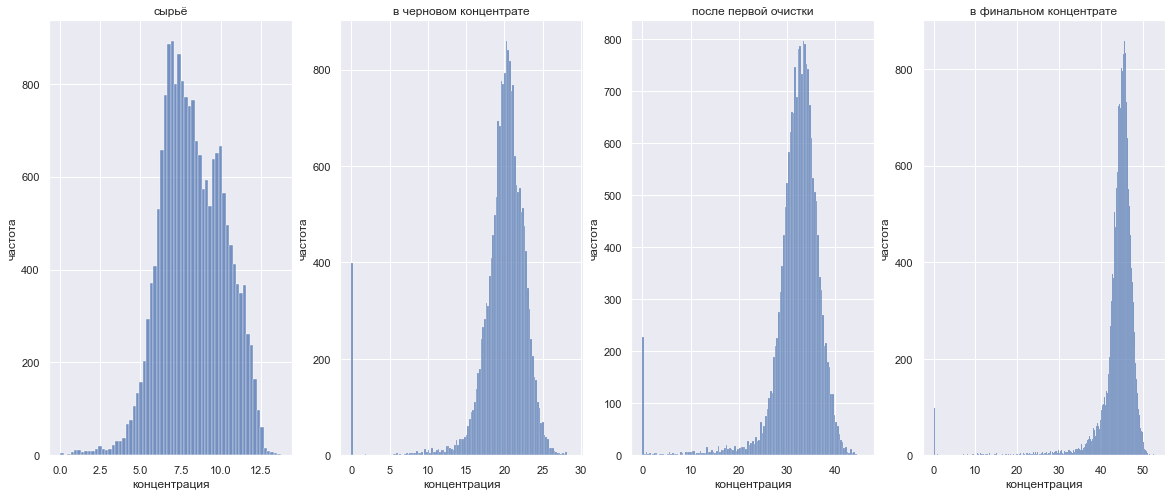

In [268]:
look_concentrate('Au', 
                 'rougher.input.feed_au', 
                 'rougher.output.concentrate_au', 
                 'primary_cleaner.output.concentrate_au', 
                 'final.output.concentrate_au',
                 df_full)

Смотрим на концентрацию Ag на разных этапах


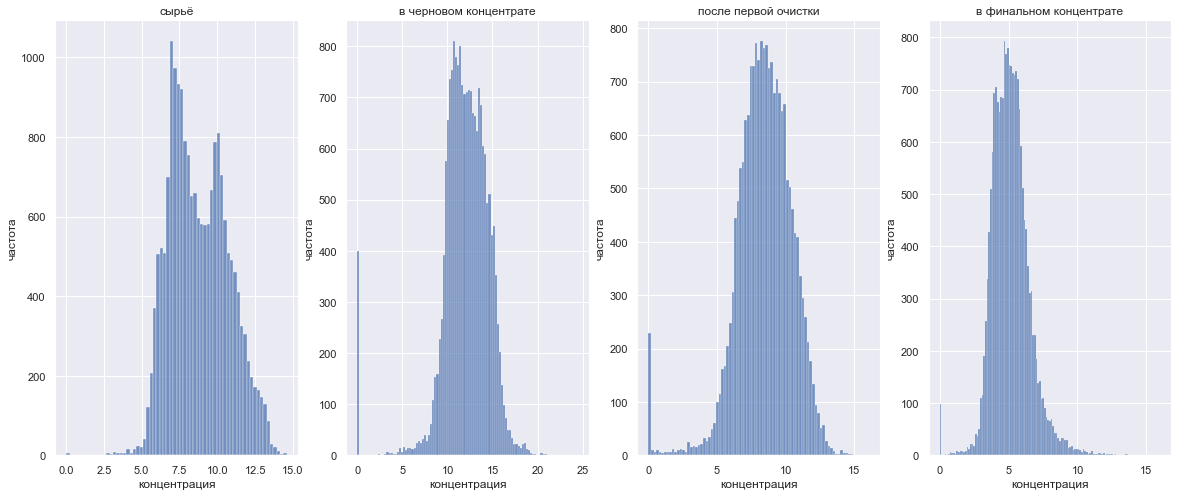

In [269]:
look_concentrate('Ag', 
                 'rougher.input.feed_ag', 
                 'rougher.output.concentrate_ag', 
                 'primary_cleaner.output.concentrate_ag', 
                 'final.output.concentrate_ag',
                 df_full)

Смотрим на концентрацию Pb на разных этапах


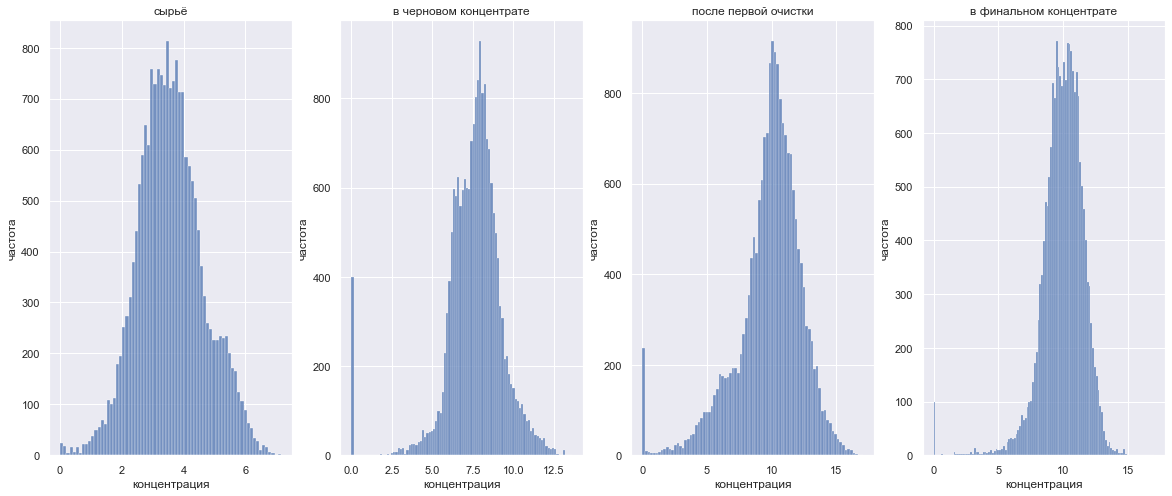

In [270]:
look_concentrate('Pb', 
                 'rougher.input.feed_pb', 
                 'rougher.output.concentrate_pb', 
                 'primary_cleaner.output.concentrate_pb', 
                 'final.output.concentrate_pb',
                 df_full)

С каждым этапом хорошо виден рост концентрации золота. Максимум распределения приходится примерно на 7.5 - 20 - 33 - 45.
Концентрация серебра на первом этапе увеличивается, потом уменьшается. максимум приходится примерно на 7.5 - 11 - 7.5 - 5
Концентрация свинца по чуть растет: примерно 3.5 - 7.5 - 10 - 10
Судя повсему от свинца избавиться сложнее.
Так же можно отметить, что по всем металлам разброс распределения снижается (визуально видно постепенное сужение гистограмм)

**2.2.**  Сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках.

In [271]:
# размеры гранул только на этапах сырья и первичной очистки
feed_size_list = []
for column in df_full.columns:
    if 'feed_size' in column:
        print(column)
        feed_size_list.append(column)

rougher.input.feed_size
primary_cleaner.input.feed_size


Размер гранул на этапе сырья


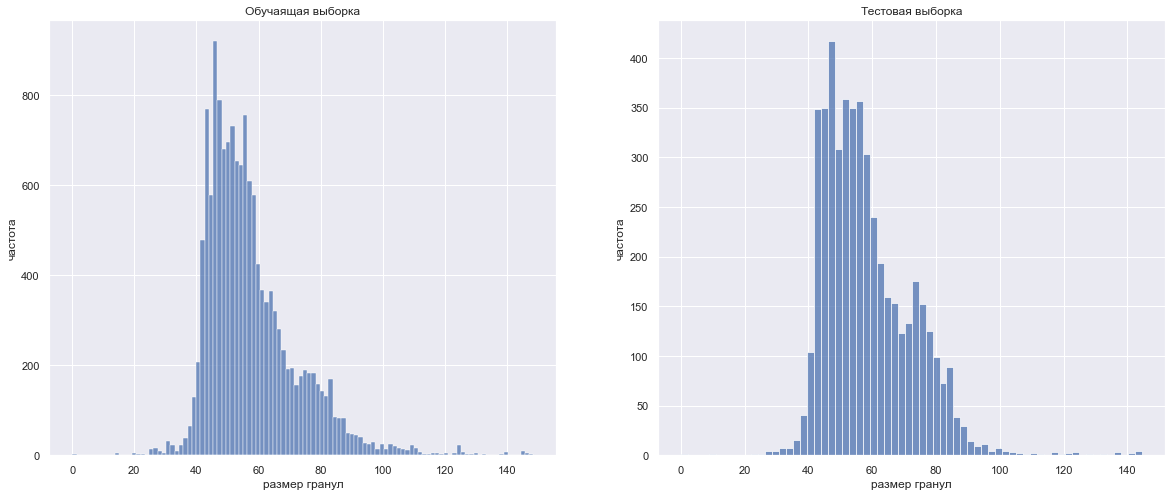

In [272]:
print('Размер гранул на этапе сырья')
look_feed_size(feed_size_list[0], df_train, "Обучаящая выборка", df_test, 'Тестовая выборка')

Размер гранул на этапе очистки


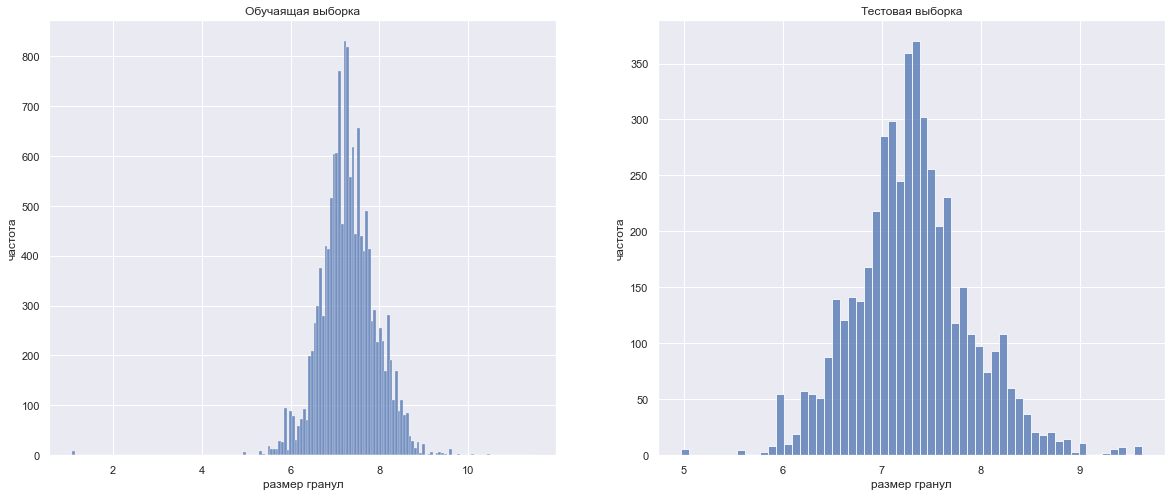

In [273]:
print('Размер гранул на этапе очистки')
look_feed_size(feed_size_list[1], df_train, "Обучаящая выборка", df_test, 'Тестовая выборка', 12)

Видим, что размер гранул на этапе сырья и на этапе очистки между обучающей и тестовой выборкой совпадают. На этапе сырья пик распределения приходится на 40-60, на этапе очистки гранулы уже существенно меньше, пик распределения у обеих выборок приходится 7 - 7.5

**2.3.** Исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Суммарная концентрация металлов на входе


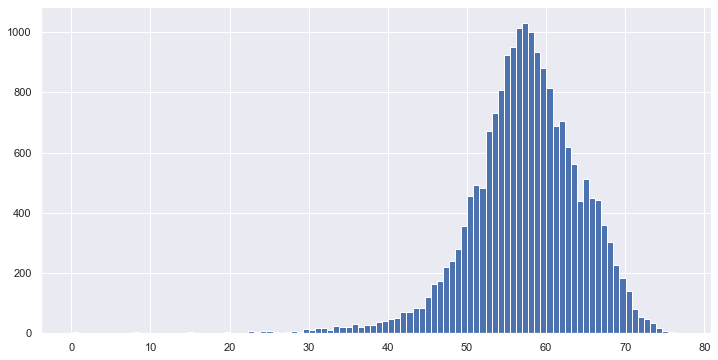

In [274]:
print('Суммарная концентрация металлов на входе')
roucher_feed_sum_conc = (df_full['rougher.input.feed_au'] + 
                   df_full['rougher.input.feed_ag'] + 
                   df_full['rougher.input.feed_pb'] +
                   df_full['rougher.input.feed_sol'])

sns.set(rc={'figure.figsize':(12,6)})
roucher_feed_sum_conc.hist(bins=100);

Суммарная концентрация металлов в черновом концентрате


<AxesSubplot:>

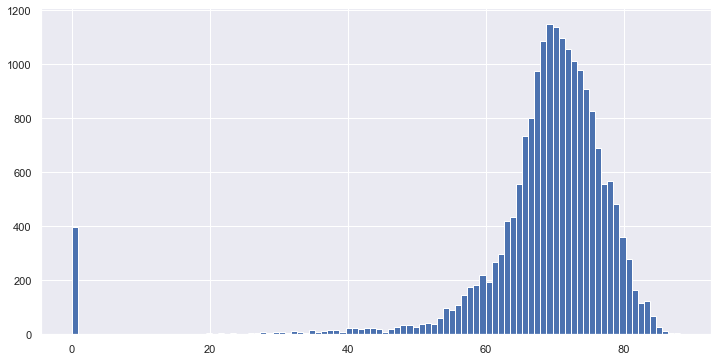

In [275]:
print('Суммарная концентрация металлов в черновом концентрате')
roucher_sum_conc = (df_full['rougher.output.concentrate_au'] + 
                   df_full['rougher.output.concentrate_ag'] + 
                   df_full['rougher.output.concentrate_pb'] +
                   df_full['rougher.output.concentrate_sol'])

roucher_sum_conc.hist(bins=100)

Суммарная концентрация металлов в концентрате после первой очистки


<AxesSubplot:>

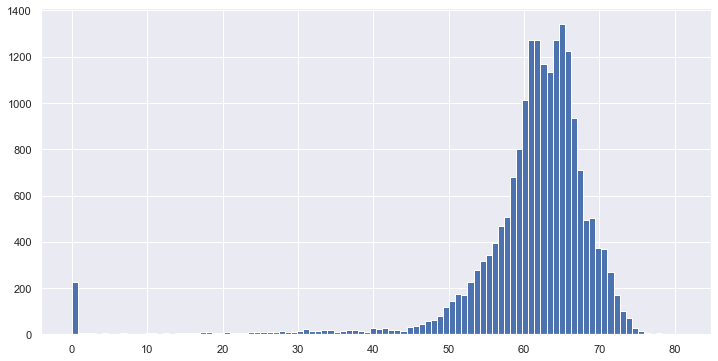

In [276]:
print('Суммарная концентрация металлов в концентрате после первой очистки')
primary_cleaner_sum_conc = (df_full['primary_cleaner.output.concentrate_au'] + 
                   df_full['primary_cleaner.output.concentrate_ag'] + 
                   df_full['primary_cleaner.output.concentrate_pb'] +
                   df_full['primary_cleaner.output.concentrate_sol'])

primary_cleaner_sum_conc.hist(bins=100)

Суммарная концентрация металлов в финале


<AxesSubplot:>

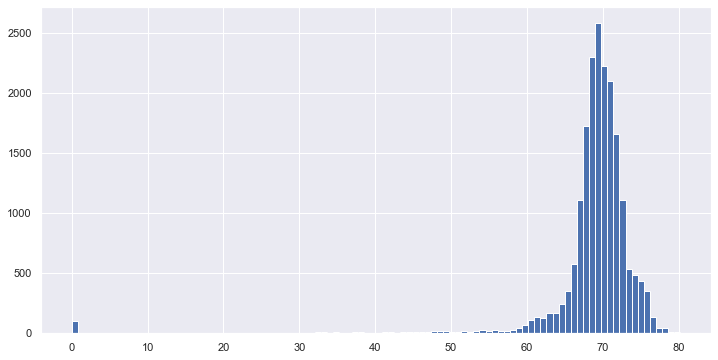

In [277]:
print('Суммарная концентрация металлов в финале')
final_sum_conc = (df_full['final.output.concentrate_au'] + 
                   df_full['final.output.concentrate_ag'] + 
                   df_full['final.output.concentrate_pb'] +
                   df_full['final.output.concentrate_sol'])

final_sum_conc.hist(bins=100)

Суммарная концентрация металлов увеличивается по этапно примерно с 55 на входе до 70 на выходе. Плюс уменьшается рассеяние.  
Так же можно отметить, что появляются какие-то околонулевые хвосты.  

Потом посмотрим, лучше их оставить, заполнить, как и пропуски, или грохнуть.

In [278]:
# грохнем нули во всех датасетах
df_train = df_train[~(roucher_sum_conc == 0)]
df_train = df_train[primary_cleaner_sum_conc > 0.04]
df_train = df_train[~(final_sum_conc == 0)]

df_test = df_test[~(roucher_sum_conc == 0)]
df_test = df_test[primary_cleaner_sum_conc > 0.04]
df_test = df_test[~(final_sum_conc == 0)]

df_full = df_full[~(roucher_sum_conc == 0)]
df_full = df_full[primary_cleaner_sum_conc > 0.04]
df_full = df_full[~(final_sum_conc == 0)]

print("Проверка размерности сетов: ", df_train.shape, df_test.shape, df_full.shape)

Проверка размерности сетов:  (13890, 86) (4841, 52) (18731, 86)


**Предварительные выводы**  
- Посмотрели распределения концентрации металов отдельно и в сумме в зависимости от стадии обработки. Отметили существенный рост концентрации золота и суммарной концентрации. Так же отметили, что уменьшается разброс концентрации с прохождением этапов обработки.  
- Сравнили размеры гранул на начальном этапе и этапе обработки. После обработки размер гранул существенно меньше. Так же определили, что размеры гранул обучающей и тестовой выборки совпадают.

## Модель

у нас два целевых признака:  
- rougher.output.recovery
- final.output.recovery
Так же мы принимаем, что у нас условия приближенные к реальности. Учиться и смотреть метрики качетсва мы будем на обучающей выборке. В итоге проверим все на тестовой.

In [279]:
# Поиграемся с выбросами

# сделаем копию трэйна
df_droped = df_train.copy()

# Дропне по IQR и офигеем что останется
print('df_droped до дропа', df_droped.shape)
df_droped = drop_output_iqr(df_droped)
print('df_droped после дропа', df_droped.shape)

print("-"*40)
df_droped = df_train.copy()

# возьмем 95% от выборки и тоже офигеем
print('df_droped до дропа', df_droped.shape)
df_droped = drop_output_95(df_droped)
print('df_droped после дропа', df_droped.shape)

df_droped до дропа (13890, 86)
df_droped после дропа (852, 86)
----------------------------------------
df_droped до дропа (13890, 86)
df_droped после дропа (152, 86)


In [280]:
# методом тыка подобрали приемлый уровень
print('df_train до дропа', df_train.shape)
df_train = drop_output_95(df_train, 0.001, 0.999)
print('df_train после дропа', df_train.shape)

df_train до дропа (13890, 86)
df_train после дропа (11813, 86)


In [281]:
# признаки и целевые для обучения. Валидационную выделять не будем, будет кросс-валидация
X_train = df_train[features]
y_roughher_train = df_train[['rougher.output.recovery']]
y_final_train = df_train[['final.output.recovery']]

# признаки и целевые для теста.
X_test = df_test
y_roughher_test = df_full.loc[df_test.index][['rougher.output.recovery']]
y_final_test = df_full.loc[df_test.index][['final.output.recovery']]

print(f"""Проверка
X_train - {X_train.shape}
y_roughher_train - {y_roughher_train.shape}
y_final_train - {y_final_train.shape}

X_test - {X_test.shape}
y_roughher_test - {y_roughher_test.shape}
y_final_test - {y_final_test.shape}""")

Проверка
X_train - (11813, 52)
y_roughher_train - (11813, 1)
y_final_train - (11813, 1)

X_test - (4841, 52)
y_roughher_test - (4841, 1)
y_final_test - (4841, 1)


Для моделек выберем:
- RandomForestRegressor (всегда показывает лучшие результаты)
- LinearSVR (хочется поковырять что то новое)
- LinearRegression (самая быстрая, и ее можно использовать как думми, если у других моделей оценка ниже чем у нее, значит гдето косяк )))

In [282]:
# 1. RandomForestRegressor. соберем простенький пайплайн с подбором гиперпараметров по сетке

pipe = Pipeline(steps=[
                    #('fillna', SimpleImputer(missing_values=np.nan, strategy="median")),
                    ('scaler', StandardScaler()),
                    ('anova_filter', SelectKBest(f_classif, k=20)),
                    #('poly', PolynomialFeatures(degree=(1,2), include_bias=False)),
                    ('regressor', RandomForestRegressor())
                    ])

param_grid = {'regressor__n_estimators':[50, 100],
              #'regressor__criterion':['gini', 'entropy'],
              'regressor__max_depth':[x for x in range(3,5)],
              'regressor__min_samples_split':[x for x in range(4,6)],
              'regressor__min_samples_leaf':[x for x in range(4,6)],
              }

grid_search_rfr1  = GridSearchCV(pipe,
                               param_grid, 
                               scoring = make_scorer(smape, greater_is_better=False), 
                               n_jobs=-1, 
                               cv=5
                               )

grid_search_rfr2 = GridSearchCV(pipe,
                               param_grid, 
                               scoring = make_scorer(smape, greater_is_better=False), 
                               n_jobs=-1, 
                               cv=5
                               )

In [283]:

grid_search_rfr1.fit(X_train, y_roughher_train)
grid_search_rfr2.fit(X_train, y_final_train)

print(grid_search_rfr1.best_params_)
print(-grid_search_rfr1.best_score_)
print('-'*40)
print(grid_search_rfr2.best_params_)
print(-grid_search_rfr2.best_score_)


{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 100}
7.41888106055313
----------------------------------------
{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 50}
9.682280850807022


In [284]:
# 2. LinearSVR. соберем простенький пайплайн с подбором гиперпараметров по сетке

pipe = Pipeline(steps=[
                    #('fillna', SimpleImputer(missing_values=np.nan, strategy="median")),
                    ('scaler', StandardScaler()),
                    ('anova_filter', SelectKBest(f_classif, k=12)),
                    ('poly', PolynomialFeatures(degree=(1,2), include_bias=False)),
                    ('regressor', LinearSVR())
                    ])

param_grid = {
    'regressor__loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'regressor__dual':[True, False],
    'regressor__C':[1, 0.1, 0.001, 0.01]
}

grid_search_lsvr1 = GridSearchCV(pipe,
                               param_grid, 
                               scoring = make_scorer(smape, greater_is_better=False), 
                               n_jobs=-1, 
                               cv=5
                               )

grid_search_lsvr2 = GridSearchCV(pipe,
                               param_grid, 
                               scoring = make_scorer(smape, greater_is_better=False), 
                               n_jobs=-1, 
                               cv=5
                               )

In [285]:
grid_search_lsvr1.fit(X_train, y_roughher_train)
grid_search_lsvr2.fit(X_train, y_final_train)

print(grid_search_lsvr1.best_params_)
print(-grid_search_lsvr1.best_score_)
print('-'*40)
print(grid_search_lsvr2.best_params_)
print(-grid_search_lsvr2.best_score_)

{'regressor__C': 0.1, 'regressor__dual': True, 'regressor__loss': 'squared_epsilon_insensitive'}
7.51956412150931
----------------------------------------
{'regressor__C': 0.01, 'regressor__dual': False, 'regressor__loss': 'squared_epsilon_insensitive'}
12.698986436619782


In [294]:
# 3. LinearRegressor. соберем простенький пайплайн. По сетке подбирать особо нечего (поучимся в сетке выбирать уменьшение размерности)

pipe = Pipeline(steps=[
                    #('fillna', SimpleImputer(missing_values=np.nan, strategy="median")),
                    ('scaler', StandardScaler()),
                    # the reduce_dim stage is populated by the param_grid
                    ("reduce_dim", "passthrough"),
                    #('anova_filter', SelectKBest(f_classif, k=4)),
                    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
                    ('regressor', LinearRegression())
                    ])

N_FEATURES_OPTIONS = [x for x in range(2,20)]
param_grid = [
    {   
        "reduce_dim": [PCA(iterated_power=7), NMF(max_iter=1_000)],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
    },
    {
        "reduce_dim": [SelectKBest(f_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
    },
]
reducer_labels = ["PCA", "NMF", "SelectKBest(f_classif)"]

"""
param_grid = {#'regressor__penalty':['l1', 'l2', 'elasticnet', None],
              #'regressor__C': [0.1, 0.25, 0.5, 1],
              'regressor__fit_intercept':[True, False],
              #'regressor__solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              #'regressor__multi_class':['auto', 'ovr', 'multinomial'],
              #'regressor__max_iter':[100, 500, 2000]
              }
"""
              
grid_search_lr1 = GridSearchCV(pipe, 
                              param_grid = param_grid, 
                              scoring = make_scorer(smape, greater_is_better=False), 
                              n_jobs=-1, 
                              cv=5)

grid_search_lr2 = GridSearchCV(pipe, 
                              param_grid = param_grid, 
                              scoring = make_scorer(smape, greater_is_better=False), 
                              n_jobs=-1, 
                              cv=5)

In [295]:
grid_search_lr1.fit(X_train, y_roughher_train)
grid_search_lr2.fit(X_train, y_final_train)

print(grid_search_lr1.best_params_)
print(-grid_search_lr1.best_score_)
print('-'*40)
print(grid_search_lr2.best_params_)
print(-grid_search_lr2.best_score_)

{'reduce_dim': SelectKBest(k=7), 'reduce_dim__k': 7}
5.228380334447133
----------------------------------------
{'reduce_dim': PCA(iterated_power=7, n_components=2), 'reduce_dim__n_components': 2}
8.003275483893436


In [292]:
# проверим лучшую модель на тесте

y_roughher_pred = grid_search_lr1.predict(X_test)
y_final_pred = grid_search_lr2.predict(X_test)

print("для признака - rougher.output.recovery sMAPE:", smape(y_roughher_pred, y_roughher_test))
print("для признака - final.output.recovery sMAPE:", smape(y_final_pred, y_final_test))

для признака - rougher.output.recovery sMAPE: 5.041110677290433
для признака - final.output.recovery sMAPE: 9.04453117625168


In [293]:
print("Итоговое sMAPE:", smape_itog(y_roughher_pred, y_roughher_test, y_final_pred, y_final_test))

Итоговое sMAPE: 8.043676051511367


In [299]:
# Проверим на адекатность модель
dummy_regr1 = DummyRegressor(strategy="mean")
dummy_regr2 = DummyRegressor(strategy="mean")

dummy_regr1.fit(X_train, y_roughher_train)
dummy_regr2.fit(X_train, y_final_train)

y_roughher_pred_dummy = dummy_regr1.predict(X_test)
y_final_pred_dummy = dummy_regr2.predict(X_test)

print("Dummy для признака - rougher.output.recovery sMAPE:", smape(y_roughher_pred_dummy, y_roughher_test))
print("Dummy для признака - final.output.recovery sMAPE:", smape(y_final_pred_dummy, y_final_test))

Dummy для признака - rougher.output.recovery sMAPE: 5.986624599690874
Dummy для признака - final.output.recovery sMAPE: 9.121955096844736


мда, модель не сильно лучше думми... но чуть лучше

**Предварительные выводы**  
- Покрутили разные модели: Случайный лес, новую модельку - LinearSVR и обычную линейную регрессию.
- Модельки крутили через пайплайн и грид серч, в нем же применяли кросс-валидацию. 
- Там же добавляли полиномиальные признаки и выбирали KBest фичей.
- в качестве оценки моделей использовали самописную метрику sMAPE

Лучше всего отработала линейная регрессия. Меня до сих пор не покаидает мысль, что у меня где-то косяк, так как раньше никогда такого не было.  
Понятно что мы оптимизировали по сетке для нее количество значимых признаков, но всё равно...

**Выводы**  
1. загрузили и предварительно посмотрели данные.
- полных дубликатов нет
- Пропуски есть. Много по столбцам и прилично по строкам. Вариантов обработки несколько:  
    - простой способ - fillna медианой, средним, предыдущим или следующим значением
    - чуть сложнее - средним между соседними значениями
    - еще чуть сложнее предсказать через другие признаки или как временного ряда с помощью ARIMA
- Так как имеем жесткий дэдлайн применили метод ffill, так как видно что данные временного ряда на каждом шаге меняются незначительно
- Определили что есть выбросы, если смотреть по межквартильному расстоянию практически во всех признаках. 
- Определили, что между целевыми признаками есть корреляция (существенная, но не 1. на уровне 0.33) 
- Проверили правильность расчета выхода годного на обучаещей выборке для признака rougher.output.recovery
2. Проанализировали данные
- Посмотрели распределения концентрации металов отдельно и в сумме в зависимости от стадии обработки. Отметили существенный рост концентрации золота и суммарной концентрации. Так же отметили, что уменьшается разброс концентрации с прохождением этапов обработки.  
- Сравнили размеры гранул на начальном этапе и этапе обработки. После обработки размер гранул существенно меньше. Так же определили, что размеры гранул обучающей и тестовой выборки совпадают.
- Выявили существенную часть нулевых признаков признаков, удалили, так как нет возможности посоветоваться с экспертом по методу их заполнения.
3. Модель
- Покрутили разные модели: Случайный лес, новую модельку - LinearSVR и обычную линейную регрессию.
- Модельки крутили через пайплайн и грид серч, в нем же применяли кросс-валидацию. 
- Там же добавляли полиномиальные признаки и выбирали KBest фичей.
- в качестве оценки моделей использовали самописную метрику sMAPE
- Итоговую метрику sMape получили на уровне 7.43
- Дропнули выбросы, улучшили качество модели до (было 7.63 стало 7.43)


## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке выполнения
- [ ]  Выполнен шаг 1: данные подготовлены
    - [ ]  Проверена формула вычисления эффективности обогащения
    - [ ]  Проанализированы признаки, недоступные в тестовой выборке
    - [ ]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [ ]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке